## Μοντέλο με τη χρήση Νευρωνικών Δικτύων για την πρόβλεψη μετοχών

In [1]:
# Εισαγωγή βιβλιοθηκών
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Λήψη δεδομένων από το Yahoo Finance
symbol = 'AMZN'  # Παρ΄΄αδειγμα μετοχ΄ής για την Amazon
start_date = '2018-01-01'
end_date = '2023-11-30'
df = yf.download(symbol, start=start_date, end=end_date)
df['Date'] = df.index

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Καθαρισμός των δεδομένων και προεπεξεργασία
df.isnull().sum()
df.dropna(inplace=True)

In [4]:
close_prices = df['Close'].values.reshape(-1, 1)

In [5]:
# Κανονικοποίηση δεδομένων
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [6]:
# Προετοιμασία δεδομένων για το μοντέλο
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [7]:
# Διαχωρισμός σε train και test set
time_step = 60
X, y = create_dataset(scaled_data, time_step)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [8]:
# Μετατροπή σε 3D μορφή για το LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Χτίσιμο του μοντέλου LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
# Εκπαίδευση του μοντέλου
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=5) # Εκπαίδευση για 5 εποχές

Epoch 1/5
1141/1141 [==============================] - 50s 36ms/step - loss: 0.0045
Epoch 2/5
1141/1141 [==============================] - 39s 34ms/step - loss: 0.0017
Epoch 3/5
1141/1141 [==============================] - 35s 31ms/step - loss: 0.0013
Epoch 4/5
1141/1141 [==============================] - 37s 33ms/step - loss: 0.0011
Epoch 5/5
1141/1141 [==============================] - 40s 35ms/step - loss: 9.1509e-04


In [11]:
# Αξιολόγηση του μοντέλου για την πρόβλεψη του μοντέλου στο train και test set
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 27ms/step


In [12]:
# Μετατροπή των δεδομένων σε αρχική μορφή
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [13]:
# Υπολογισμός του start index
test_start_index = len(scaled_data) - len(test_predict) - 1

In [14]:
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[test_start_index:test_start_index + len(test_predict), :] = test_predict

In [22]:
# Υπολογισμός του MAE, MSE και RMSE για το train set
train_mae = mean_absolute_error(y_train, scaler.inverse_transform(model.predict(X_train)))
train_mse = mean_squared_error(y_train, scaler.inverse_transform(model.predict(X_train)))
train_rmse = np.sqrt(train_mse)

36/36 [==============================] - 1s 22ms/step


In [16]:
# Υπολογισμός του MAE, MSE και RMSE για το test set
test_mae = mean_absolute_error(y_test, scaler.inverse_transform(model.predict(X_test)))
test_mse = mean_squared_error(y_test, scaler.inverse_transform(model.predict(X_test)))
test_rmse = np.sqrt(test_mse)

9/9 [==============================] - 0s 22ms/step


In [17]:
print("Training Data Evaluation:")
print("MAE:", train_mae)
print("MSE:", train_mse)
print("RMSE:", train_rmse)

Training Data Evaluation:
MAE: 124.71025471656876
MSE: 16754.227081689394
RMSE: 129.438120666554


In [18]:
print("\nTesting Data Evaluation:")
print("MAE:", test_mae)
print("MSE:", test_mse)
print("RMSE:", test_rmse)


Testing Data Evaluation:
MAE: 115.57398267978468
MSE: 13687.041678582149
RMSE: 116.9916308057211


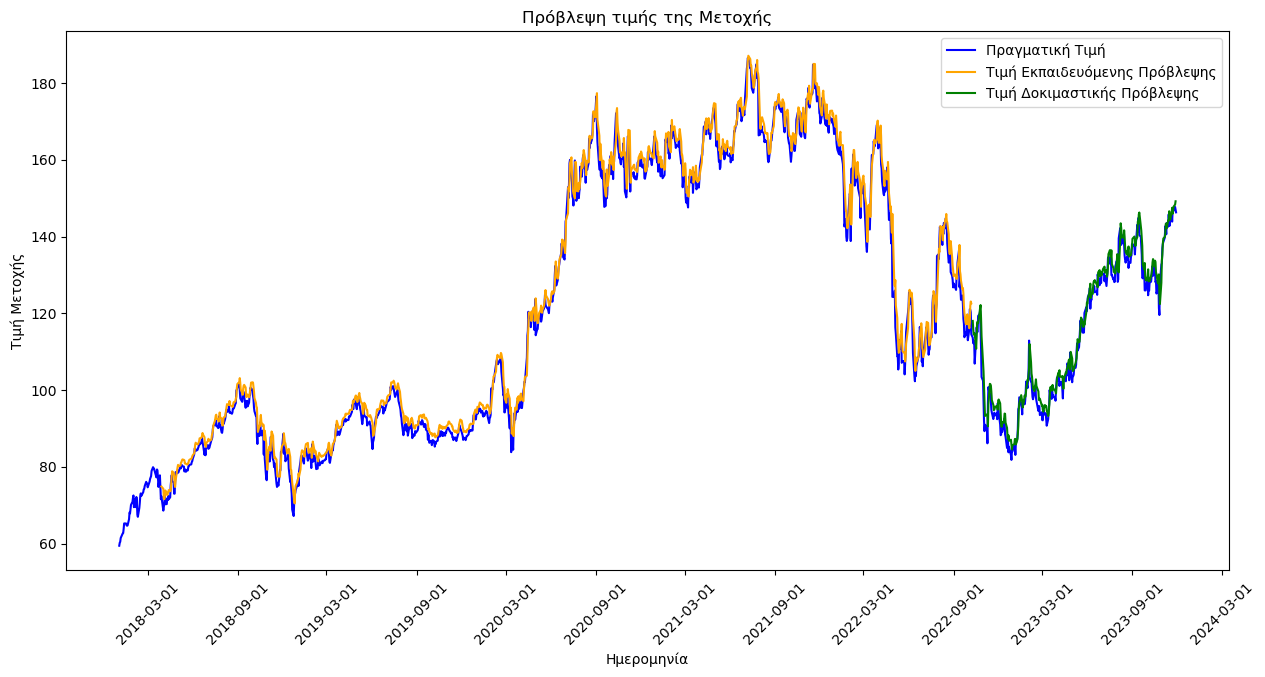

In [23]:
# Οπτικοποίηση των αποτελεσμάτων
plt.figure(figsize=(15,7))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Πραγματική Τιμή', color='blue')
plt.plot(df.index, trainPredictPlot, label='Τιμή Εκπαιδευόμενης Πρόβλεψης', color='orange')
plt.plot(df.index, testPredictPlot, label='Τιμή Δοκιμαστικής Πρόβλεψης', color='green')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.xlabel('Ημερομηνία')
plt.ylabel('Τιμή Μετοχής')
plt.title('Πρόβλεψη τιμής της Μετοχής')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [20]:
# Πρόβλεψη τιμών για τις επόμενες 5 μέρες
future_days = 5
future_predictions = []

# Παίρνουμε τα δεδομένα για την τελευταία μέρα
last_time_step_data = scaled_data[-time_step:]

# Μετατροπή των δεδομένων σε 3D μορφή για το LSTM
current_batch = last_time_step_data.reshape((1, time_step, 1))

# Πρόβλεψη τιμών για τις επόμενες 5 μέρες
for i in range(future_days):
    future_pred = model.predict(current_batch)[0]
    future_predictions.append(future_pred)
    current_batch = np.append(current_batch[:,1:,:], [[future_pred]], axis=1)

# Αντιστροφή της κανονικοποίησης
future_predictions = scaler.inverse_transform(future_predictions)

# Δημιουργία Pandas Series για τις μελλοντικές ημερομηνίες και τις προβλεπόμενες τιμές
future_dates = pd.date_range(start=df.index[-1], periods=future_days, freq='B')  # 'B' denotes business day frequency
future_dates_series = pd.Series(future_dates, name='Date')
future_predictions_series = pd.Series(np.reshape(future_predictions, (future_days,)), name='Predicted Close')

# Συνδυασμός των dates και των προβλεπόμενων τιμών σε ένα DataFrame
future_predictions_df = pd.concat([future_dates_series, future_predictions_series], axis=1)

1/1 [==============================] - 0s 33ms/step


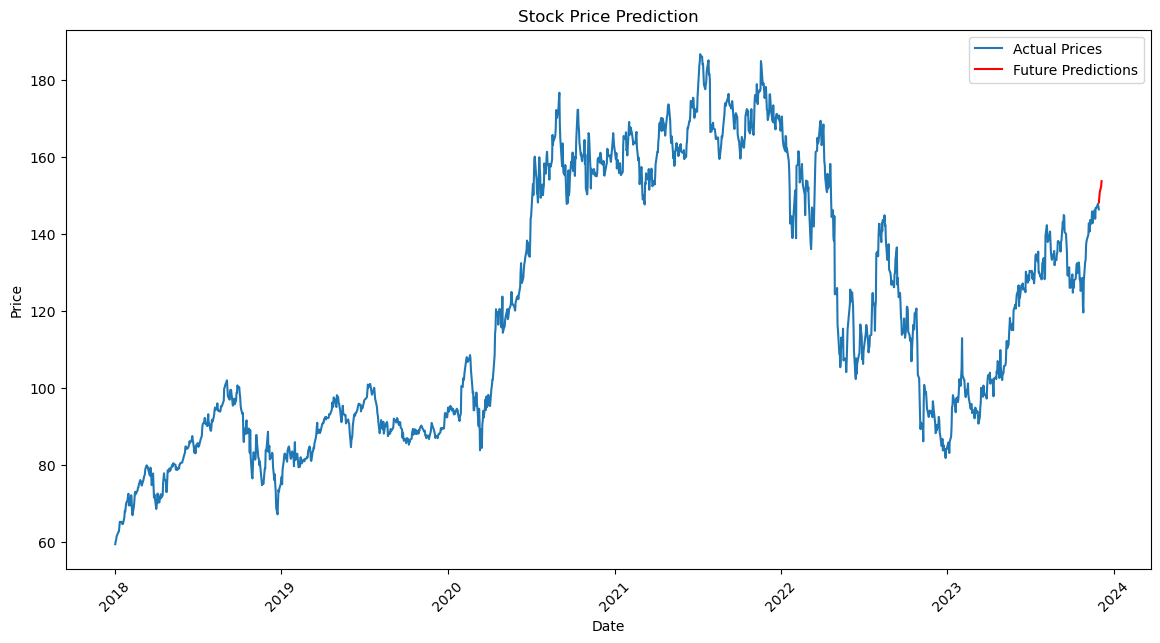

In [21]:
# Οπτικοποίηση των προβλεπόμενων τιμών
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Actual Prices')

plt.plot(future_predictions_df.set_index('Date'), label='Future Predictions', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()